# Portfolio Optimization

Questo notebook userà tutto ciò che vediamo sulla portfolio optimization, ma sui dati reali di S&P500

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("./data/sp500sub.csv", parse_dates=True, index_col="Date")

In [3]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Name'], dtype='object')

In [4]:
df["Name"].unique()

array(['INCY', 'GILD', 'DXC', 'AFL', 'XYL', 'ARE', 'AMD', 'WYNN', 'IBM',
       'ATVI', 'AES', 'GPC', 'PRU', 'HST', 'WMB', 'GOOG', 'SRE', 'HSIC',
       'UNP', 'UPS', 'K', 'LYB', 'MDT', 'COF', 'HAS', 'CSX', 'GT', 'SYF',
       'EBAY', 'KSS', 'AJG', 'JWN', 'SBUX', 'IT', 'PH', 'DVN', 'MMM',
       'SPG', 'AKAM', 'IP', 'CPB', 'KMI', 'AAPL', 'NEM', 'KMX', 'TSCO',
       'SYY', 'VNO', 'NWS', 'NBL', 'ACN', 'APH', 'PDCO', 'WLTW', 'FIS',
       'URI', 'CBOE', 'FISV', 'BA', 'UAA', 'CVS', 'WU', 'SLB', 'AIV',
       'VLO', 'MU', 'CAH', 'AZO', 'CCI', 'ZTS', 'MCO', 'ALLE', 'RHI',
       'UAL', 'IR', 'CB', 'VMC', 'GD', 'AAP', 'NEE', 'ABT', 'WFC', 'DIS',
       'SNA', 'MAR', 'JPM', 'CLX', 'KIM', 'SCG', 'HBI', 'ABBV', 'RSG',
       'ETR', 'ADBE', 'COO', 'HLT', 'INTU', 'SLG', 'GWW', 'COG', 'CBS',
       'FB', 'CMS', 'MDLZ'], dtype=object)

In [5]:
# La scelta dei settori differenti aiuta la diversificazione e riduce la correlazione tra azioni
names = ["GOOG", "SBUX", "KSS", "NEM"]

In [6]:
# Numero di trading days in un anno = 252. Vogliamo simulare un bilanciamento di portfolio semestrale, quindi
print(252/2, "giorni")

126.0 giorni


In [7]:
# Prendiamo tutte le date presenti nel dataframe.
# Escludiamo tutte le date di mercato dove non esistono giorni di trading. Per farlo, ci basiamo unicamente sulle date riportate nel csv
# prendiamo gli indici (date), li rendiamo unici e li mettiamo in ordine
all_dates = df.index.unique().sort_values()

In [8]:
len(all_dates)

2267

In [9]:
# Prendiamo la posizione (indice numerico) della data di partenza. 
start = all_dates.get_loc('2014-01-02')
start

1007

In [10]:
# Prendiamo la posizione (indice numerico) di 6 mesi dopo
end = all_dates.get_loc('2014-06-30')
end

1130

In [11]:
# prendiamo tutte le date tra gli indici
dates = all_dates[start:end+1]

In [12]:
type(dates), len(dates)

(pandas.core.indexes.datetimes.DatetimeIndex, 124)

In [13]:
# Creiamo un dataframe apposito nelle date specificate
close_prices = pd.DataFrame(index=dates)

In [14]:
# Creiamo il DF incrementalmente:
tmp1 = df.loc[dates]
for name in names:
    df_sym = tmp1[tmp1["Name"] == name]
    df_tmp = pd.DataFrame(data=df_sym["Close"].to_numpy(), index=df_sym.index, columns=[name])
    close_prices = close_prices.join(df_tmp) # left join by default

In [15]:
close_prices.head()

,GOOG,SBUX,KSS,NEM
Date,,,,
2014-01-02,554.481689,38.584999,56.990002,23.959999
2014-01-03,550.436829,38.474998,56.860001,23.920000
2014-01-06,556.573853,38.084999,56.040001,24.080000
2014-01-07,567.303589,38.605000,56.099998,23.950001
2014-01-08,568.484192,39.014999,55.180000,23.400000


In [16]:
close_prices.isna().sum().sum()

0

In [17]:
# In caso di NaNs
close_prices.ffill(inplace=True)

In [18]:
# Creiamo un nuovo dataframe per storare i returns. Siccome avremo una data in meno, gli indici partiranno da 1
returns = pd.DataFrame(index=close_prices.index[1:])


In [19]:
for name in names:
    current_returns = close_prices[name].pct_change() # Log returns
    returns[name] = current_returns.iloc[1:] * 100

In [20]:
returns.head()

,GOOG,SBUX,KSS,NEM
Date,,,,
2014-01-03,-0.729485,-0.285086,-0.228112,-0.166941
2014-01-06,1.114937,-1.013644,-1.442138,0.668896
2014-01-07,1.927819,1.365368,0.107062,-0.539864
2014-01-08,0.208108,1.062038,-1.639925,-2.296456
2014-01-09,-0.962997,-0.551071,0.688657,-0.854696


In [21]:
mean_returns = returns.mean()
mean_returns

GOOG    0.038691
SBUX    0.009955
KSS    -0.053793
NEM     0.072932
dtype: float64

In [22]:
cov = returns.cov()
cov

,GOOG,SBUX,KSS,NEM
GOOG,2.206565,0.832469,0.771772,-0.033600
SBUX,0.832469,1.558406,0.714586,0.374448
KSS,0.771772,0.714586,2.025854,0.180308
NEM,-0.033600,0.374448,0.180308,4.815104


In [23]:
cov_np = cov.to_numpy() # Usiamo l'array numpy perchè si gestiscono meglio gli indici

In [24]:
# Ora creiamo il solito scatterplot risk return, sulla base dei dati ottenuti dagli stocks
N = 100000 # Numero di campioni da generare
D = len(mean_returns) # Numero di stocks, in poche parole
returns = np.zeros(N)
risks = np.zeros(N)
random_weights = []

for i in range(N):
    rand_range = 1.0 # Ci permette di settare l'ampiezza dei pesi. Con rand_range = 1 abbiamo tra -0.5 e + 0.5
    w = np.random.random(D)*rand_range - rand_range/2 # Creiamo dei pesi con possibilità di short selling
    w[-1] = 1 - w[:-1].sum()
    np.random.shuffle(w) # Shuffling sempre per bilanciamento
    random_weights.append(w)
    ret = mean_returns.dot(w)
    risk = np.sqrt(w.dot(cov).dot(w))
    returns[i] = ret
    risks[i] = risk

In [25]:
# Ora calcoliamo returns e risk per portfolio a singolo asset
single_assets_returns = np.zeros(D)
single_assets_risks = np.zeros(D)
for i in range(D):
    single_assets_returns[i] = mean_returns.iloc[i]
    single_assets_risks[i] = np.sqrt(cov_np[i,i])
    

#### Considerazioni Plot

La forma del plot sotto è conosciuta come Markowitz bullet. I nostri asset individuali si possono individuare in rosso.
Possiamo notare una cosa dalla distribuzione: buona parte delle combinazioni di asset nel portfolio generano un rischio inferiore, a riprova del fatto che la diversificazione riduce la varianza. Inoltre è anche possibile vedere una cosa molto interessante:
1) Prendendo il puntino rosso a più alto return, è possibile trovare (seguendo l'orizzontale) una combinazione di asset che garantisca lo stesso return ad un rischio molto più basso.
2) Alternativamente, prendendo quello a più basso rischio, è possibile trovare una combinazione che mantenga lo stesso rischio del singolo asset ma a ritorni molto maggiori

Dalla portfolio optimization spesso si possono vedere alcuni downside. Oltre alla necessità di fare short selling per guadagnare qualcosa (si vede che i return più alti si hanno nella parte superiore del plot).
Questo deriva dal fatto che quella coda più lunga si ottiene in virtù dell'ultimo peso, calcolato come 1 - somma dei pesi. Se levassimo l'1, avremo un plot bilanciato, tuttavia errato.

Spesso, inoltre, ci troveremo nella necessità di dover investire più del capitale investito (l'ultimo peso supera di gran lunga l'1, che è il totale del capitale) per poter ottenere quei ritorni elevati in curva.

Infine, se la curva fosse perfetta, infine, la coda superiore sarebbe più inclinata per essere simmetrica alla inferiore. Invece, date le circostanze, quello che accade è che è leggermente più orizzontale. Ciò è dovuto ai limiti che abbiamo imposto ai pesi. Eliminando o cambiando quei limiti, otterremmo forme diverse

Text(0, 0.5, 'Returns')

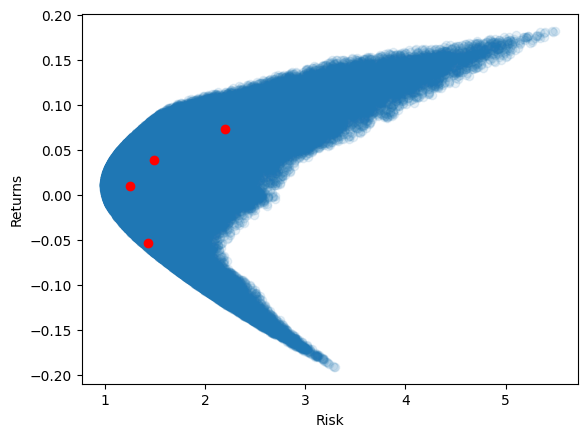

In [26]:
plt.scatter(risks, returns, alpha=0.1)
plt.scatter(single_assets_risks, single_assets_returns, c="red")
plt.xlabel("Risk")
plt.ylabel("Returns")

## Min and Max Return

In [27]:
from scipy.optimize import linprog

In [28]:
D = len(mean_returns)

In [29]:
A_eq = np.ones((1, D))
b_eq = np.ones(1)

In [30]:
### NOTA BENE: i bound di linprog non sono None di default, ma sono (0, None). Significa che di base setta tutto a maggiore di 0
# Permettiamo uno short selling del massimo 50%
bounds = [(-0.5, None)]*D # Creiamo una lista di bounds grande quanto il numero di assets
bounds

[(-0.5, None), (-0.5, None), (-0.5, None), (-0.5, None)]

In [31]:
# minimization
# ricorda. Mean returns sono il nostro mu trasposto che va moltiplicato per i pesi!
res = linprog(mean_returns, A_eq=A_eq, b_eq=b_eq, bounds=bounds)

"""
Come si leggono i risultati:
fun è il minimo return che si ottiene dai nostri stock, ed è -0.195. Si ottiene prendendo in considerazione i pesi presenti in x
in success vediamo se il programma è riuscito ad ottenere un minimo ed in genere si accompagna con status 0 (exit status)
Se i constraint non si possono rispettare, il programma può uscire unsuccessful
""";
res

        message: Optimization terminated successfully. (HiGHS Status 7: Optimal)
        success: True
         status: 0
            fun: -0.1952725235483168
              x: [-5.000e-01 -5.000e-01  2.500e+00 -5.000e-01]
            nit: 0
          lower:  residual: [ 0.000e+00  0.000e+00  3.000e+00  0.000e+00]
                 marginals: [ 9.248e-02  6.375e-02  0.000e+00  1.267e-01]
          upper:  residual: [       inf        inf        inf        inf]
                 marginals: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
          eqlin:  residual: [ 0.000e+00]
                 marginals: [-5.379e-02]
        ineqlin:  residual: []
                 marginals: []
 mip_node_count: 0
 mip_dual_bound: 0.0
        mip_gap: 0.0

In [32]:
min_return = res.fun

In [33]:
# maximization
# Passiamo il nostro c (mean_returns) con segno negativo per massimizzare
res = linprog(-mean_returns, A_eq=A_eq, b_eq=b_eq, bounds=bounds)

"""
In questo caso, per ottenere il valore reale, dobbiamo moltiplicare per -1 il fun. Allo stesso modo, dovremmo moltiplicare negativamente anche
i pesi, per ottenere quelli reali
""";
res

        message: Optimization terminated successfully. (HiGHS Status 7: Optimal)
        success: True
         status: 0
            fun: -0.18490322425695138
              x: [-5.000e-01 -5.000e-01 -5.000e-01  2.500e+00]
            nit: 0
          lower:  residual: [ 0.000e+00  0.000e+00  0.000e+00  3.000e+00]
                 marginals: [ 3.424e-02  6.298e-02  1.267e-01  0.000e+00]
          upper:  residual: [       inf        inf        inf        inf]
                 marginals: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
          eqlin:  residual: [ 0.000e+00]
                 marginals: [-7.293e-02]
        ineqlin:  residual: []
                 marginals: []
 mip_node_count: 0
 mip_dual_bound: 0.0
        mip_gap: 0.0

In [34]:
max_return = -res.fun

In [35]:
min_return, max_return

(-0.1952725235483168, 0.18490322425695138)

## Mean-Variance Optimal Portfolio

In [36]:
from scipy.optimize import minimize

In [37]:
N=100
target_returns = np.linspace(min_return, max_return, num=N)

In [38]:
# Objective Function
# Stiamo usando la programmazione quadratica, ma nulla ci vieta di prendere la radice quadrata e farla diventare lineare
def get_portfolio_variance(w, cov):
    # cov= covariance matrix
    return w.dot(cov).dot(w)

# E' il nostro constraint. I constraint in scipy devono funzionare in questo modo: ritornano 0 se sono soddisfatti
def target_return_constraints(w, mu, target):
    # mu= vectors of means
    return w.dot(mu) - target

# Constraint somma dei pesi
def portfolio_constraint(w):
    return w.sum() - 1

In [39]:
# Qui scriviamo tutti i vincoli
constraints = [
    {
        'type': 'eq',
        'fun' : target_return_constraints,
        'args' : [mean_returns, target_returns[0]] # returns will be updated during loop
    },
    {
        'type': 'eq',
        'fun' : portfolio_constraint
    }
]

In [40]:
### COME LEGGERE I RISULTATI
# II risultati importanti sono fun (minimo valore di ottimizzazione raggiunto e i pesi x.
### NB: abbiamo pesi che arrivano a +2.2
res = minimize(
    fun=get_portfolio_variance,
    x0=np.ones(D)/D,
    args=cov,
    method="SLSQP", # Sum of Least Squares Quadratic Programming -> non è vera programmazione quadratica, sempre ottimizzatore generico)
    constraints=constraints
)
res

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 10.284419897828398
       x: [-1.040e+00  2.802e-01  2.258e+00 -4.982e-01]
     nit: 8
     jac: [-6.050e-01  1.996e+00  7.765e+00 -3.704e+00]
    nfev: 42
    njev: 8

In [41]:
# Aggiungiamo i limiti ai pesi dati i risultati di prima, mettendo i bounds
res = minimize(
    fun=get_portfolio_variance,
    x0=np.ones(D)/D,
    args=cov,
    method="SLSQP", # Sum of Least Squares Quadratic Programming -> non è vera programmazione quadratica, sempre ottimizzatore generico)
    constraints=constraints,
    bounds=bounds 
)
res
# Notiamo come adesso abbiamo un fun pari a 11.22, perchè abbiamo limitato

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 11.226599316509478
       x: [-5.000e-01 -5.000e-01  2.500e+00 -5.000e-01]
     nit: 3
     jac: [ 8.534e-01  8.076e-01  8.463e+00 -4.254e+00]
    nfev: 16
    njev: 3

### Cicliamo su i target returns

In [42]:
optimized_risks = []
for target in target_returns:
    constraints[0]['args'] = [mean_returns, target] # Qui aggiorniamo i constraints ogni volta
    res = minimize(
        fun=get_portfolio_variance,
        x0=np.ones(D)/D,
        args=cov,
        method="SLSQP", # Sum of Least Squares Quadratic Programming -> non è vera programmazione quadratica, sempre ottimizzatore generico)
        constraints=constraints,
        bounds=bounds)
    optimized_risks.append(np.sqrt(res.fun)) # Appendiamo il valore della funzione obiettivo
    if res.status != 0:
        print(res)

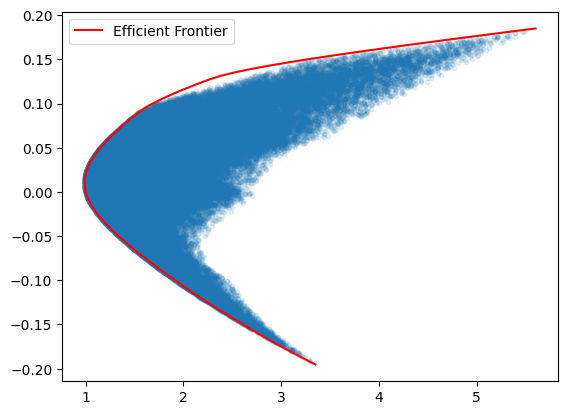

In [43]:
plt.scatter(risks, returns, alpha=0.1, marker=".")
plt.plot(optimized_risks, target_returns, c="r", label="Efficient Frontier")
plt.legend();

## Global Minimum Variable Portfolio (GMV)

In [44]:
# Minimizziamo la varianza, imponendo un vincolo ai pesi

for target in target_returns:
    constraints[0]['args'] = [mean_returns, target] # Qui aggiorniamo i constraints ogni volta
    res = minimize(
        fun=get_portfolio_variance,
        x0=np.ones(D)/D,
        args=cov,
        method="SLSQP", # Sum of Least Squares Quadratic Programming -> non è vera programmazione quadratica, sempre ottimizzatore generico)
        constraints=constraints[1], # Solo Portfolio Constraint
        bounds=bounds)
res

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.9782928256403253
       x: [ 2.234e-01  3.490e-01  2.598e-01  1.679e-01]
     nit: 4
     jac: [ 1.957e+00  1.957e+00  1.957e+00  1.957e+00]
    nfev: 23
    njev: 4

In [45]:
mv_risk = np.sqrt(res.fun) # Minimum Risk: minimum variance -> then std_dev per il plot
mv_weights = np.array(res.x)
mv_ret = mv_weights.dot(mean_returns)

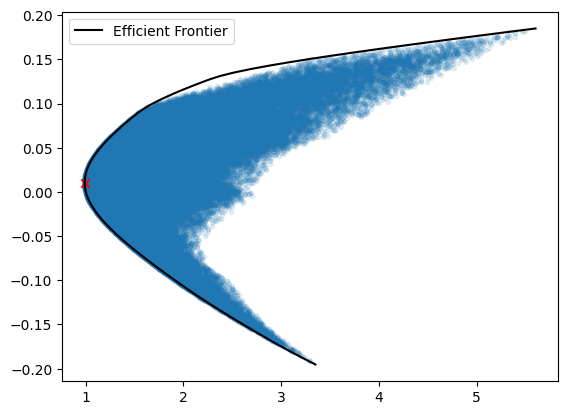

In [46]:
plt.scatter(risks, returns, alpha=0.1, marker=".")
plt.plot(optimized_risks, target_returns, c="black", label="Efficient Frontier")
plt.scatter(mv_risk, mv_ret, c="r", marker="x")
plt.legend();

In [47]:
mv_ret

0.010386902899631702

## Sharpe Ratio

In [48]:
def negative_sr(w, mean, cov):
    risk_free_rate = 0.03/252

    rets = w.dot(mean)
    sd = np.sqrt(w.dot(cov).dot(w))

    sr = (rets - risk_free_rate) / sd
    return -sr

In [49]:
res = minimize(
    fun=negative_sr,
    x0=np.ones(D)/D,
    args=(mean_returns, cov),
    method="SLSQP", # Sum of Least Squares Quadratic Programming -> non è vera programmazione quadratica, sempre ottimizzatore generico)
    constraints=constraints[1], # Solo Portfolio Constraint
    bounds=bounds)

res

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.059207597380228016
       x: [ 8.422e-01  1.183e-01 -5.000e-01  5.394e-01]
     nit: 16
     jac: [ 9.372e-03  9.290e-03  2.812e-02  9.263e-03]
    nfev: 80
    njev: 16

In [50]:
sharpe_ratio = -res.fun
best_sharpe_ratio_weights = res.x
sharpe_ratio, best_sharpe_ratio_weights

(0.059207597380228016,
 array([ 0.84222832,  0.11832916, -0.5       ,  0.53944252]))

### Giochiamo con Random Portfolio

Proviamo ad usare i portfolio che abbiamo generato prima oer vedere quali tra questi ha il miglior sharpe ratio.

Usiamo un approccio Monte Carlo, motivo per il quale abbiamo "mc" prima

In [51]:
mc_best_w = None
mc_best_sr = float('-inf')
risk_free_rate = 0.03/252


for i, (risk, ret) in enumerate(zip(risks, returns)):
    sr = (ret - risk_free_rate) / risk
    if sr > mc_best_sr:
        mc_best_sr = sr
        mc_best_w = random_weights[i]

print(mc_best_sr, mc_best_w)

0.058890057623790064 [ 0.8506508   0.15829021 -0.49175323  0.48281222]


In [52]:
mc_best_w = np.array(mc_best_w)
best_sharpe_ratio_weights = np.array(best_sharpe_ratio_weights)

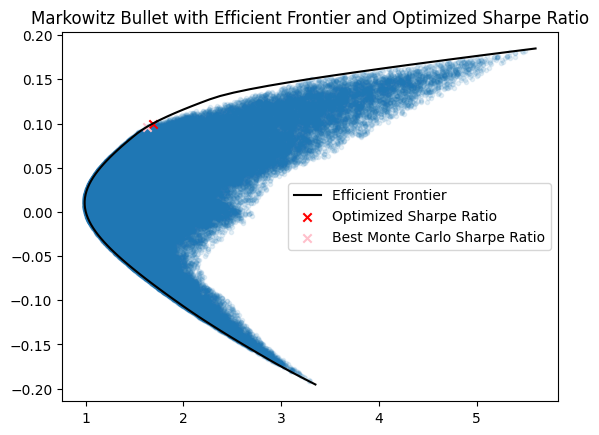

In [53]:
plt.scatter(risks, returns, alpha=0.1, marker=".")
plt.plot(optimized_risks, target_returns, c="black", label="Efficient Frontier")

# Plot Portfolio max SR con ottimizzatore
opt_sr_ret = best_sharpe_ratio_weights.dot(mean_returns)
opt_sr_std = np.sqrt(best_sharpe_ratio_weights.dot(cov).dot(best_sharpe_ratio_weights))
plt.scatter(opt_sr_std, opt_sr_ret, marker="x", c="r", label="Optimized Sharpe Ratio")

# Plot Portfolio max SR con Monte Carlo
mc_sr_rets = mc_best_w.dot(mean_returns)
mc_sr_std = np.sqrt(mc_best_w.dot(cov).dot(mc_best_w))
plt.scatter(mc_sr_std, mc_sr_rets, marker="x", c="pink", label="Best Monte Carlo Sharpe Ratio")

plt.legend()
plt.title("Markowitz Bullet with Efficient Frontier and Optimized Sharpe Ratio");



## Risk Free Asset and Tangency Portfolio

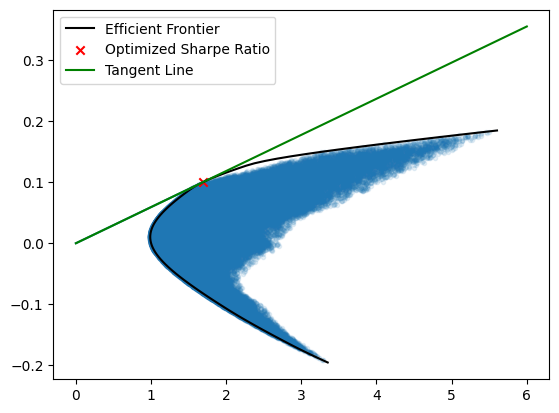

In [60]:
plt.scatter(risks, returns, alpha=0.1, marker=".")
plt.plot(optimized_risks, target_returns, c="black", label="Efficient Frontier")

# Optimal Sharpe Ratio Portfolio -> Tangency Portfolio
opt_sr_ret = best_sharpe_ratio_weights.dot(mean_returns)
opt_sr_std = np.sqrt(best_sharpe_ratio_weights.dot(cov).dot(best_sharpe_ratio_weights))
plt.scatter(opt_sr_std, opt_sr_ret, marker="x", c="r", label="Optimized Sharpe Ratio")

# Tangency line Plot
x1 = 0 # Zero Risk, Risk Free Portfolio
x2 = opt_sr_std # Risk of Optimal Sharpe Ratio (Tangency) Portfolio
y1 = risk_free_rate # Return on Risk free rate portfolio
y2 = opt_sr_ret # Return on Tangency Portfolio
plt.plot([x1,x2],[y1,y2]); # Plottiamo la linea

#### ESERCIZIO: estendiamo la retta
m = sharpe_ratio
q = risk_free_rate
x = np.linspace(0, 6, 100)
y = m*x + q
plt.plot(x, y, c="green", label="Tangent Line")

plt.legend();

### Extra exercise: Try simulating the portfolio returns

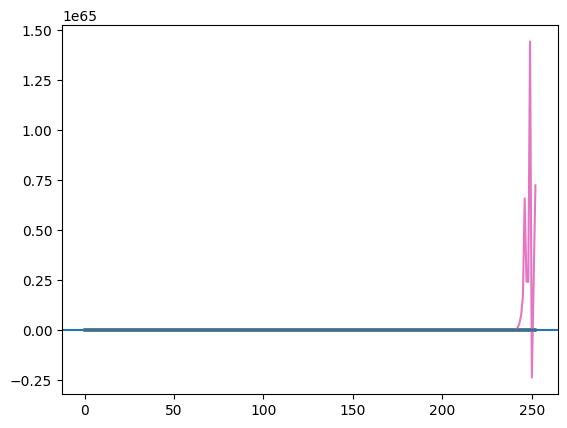

In [158]:
# Using normal distribution for ease
from scipy.stats import norm, t

N = 100
starting_price = close_prices.iloc[0]
starting_price = mc_best_w.dot(starting_price)

simulation_ends = []

for _ in range(100):
    cur_prices = [starting_price]
    for _ in range(252):
        # x2= sharpe ratio std, y2= sharpe ratio ret
        exercise_ret = t.rvs(df=2, loc=y2, scale=x2)
        #print(exercise_ret)
        new_price = cur_prices[-1]*(1 + exercise_ret)
        cur_prices.append(new_price)
    plt.plot(cur_prices)
    simulation_ends.append(new_price)
    
plt.axhline(starting_price)

In [159]:
x = np.linspace(-10, 10, 10000)
y = t.pdf(x, df=10, loc=y2, scale=x2/10)

In [160]:
starting_price, np.mean(simulation_ends), np.median(simulation_ends), np.max(simulation_ends), np.min(simulation_ends)

(461.3210818680594,
 7.244860422611649e+62,
 -2.175014771946439e+24,
 7.244860419820479e+64,
 -4.778189541277142e+53)